## Data preparation



In [1262]:
import numpy as np 
import pandas as pd
import json  # Import the json module
from pandas import json_normalize
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import get_dummies
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor



## Leser inn data


In [1263]:
df_hospital=pd.read_csv('raw_data/hospital.csv')

In [1264]:
df_physiological=pd.read_table('raw_data/physiological.txt')

##### Optimaliserer demographic filen 

In [1265]:
df_demographic=pd.read_csv('raw_data/demographic.csv')

#### Må konvertere alle objektklassene til dummy-variabler.

In [1266]:
df_demographic=get_dummies(df_demographic, columns=['kjønn', 'etnisitet']) #dummify kjønn og etnisitet.
df_demographic['kjønn'] = df_demographic['kjønn_male'] #1 representerer mann og 0 representerer kvinne. 
df_demographic.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) #dropper de orginale kolonnene, og beholder de dummified.

#dimmmify inntekt, gjør om til numerisk verdi
income_mapping= {
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3,
}
df_demographic['inntekt']=df_demographic['inntekt'].map(income_mapping)
df_demographic=df_demographic.replace({True:1, False:0}) #gjør om boolean til numerisk verdi.
df_demographic['alder'] = df_demographic['alder'].apply(lambda x : x if x > 0 else 0) #sette eventuell negativ alder til NaN
df_demographic

/var/folders/m5/8gb8vdcj5x75zn4n6ccw73n40000gn/T/ipykernel_95506/2071799546.py:13: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,pasient_id,alder,utdanning,inntekt,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,kjønn
0,2,60.33899,12.0,1.0,0,0,0,0,1,0
1,3,52.74698,12.0,0.0,0,0,0,0,1,0
2,4,42.38498,11.0,0.0,0,0,0,0,1,0
3,5,79.88495,NaN,NaN,0,0,0,0,1,0
4,6,93.01599,14.0,NaN,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
7737,9103,70.38196,NaN,NaN,0,0,0,0,1,1
7738,9104,47.01999,13.0,NaN,0,0,0,0,1,1
7739,9105,81.53894,8.0,1.0,0,0,0,0,1,0
7740,59,72.55896,NaN,NaN,0,0,0,0,1,0


In [1267]:
#Gjør om etnisitet til en kolonne

# Bruker idmax for å finne hvilken kolonne som har høyest verdi, og setter denne som etnisitet.
df_demographic['etnisitet'] = df_demographic[['etnisitet_white', 'etnisitet_black', 'etnisitet_asian', 'etnisitet_hispanic','etnisitet_other']].idxmax(axis=1)

etnisitet_mapping= {
    'etnisitet_white': 0,
    'etnisitet_black': 1,
    'etnisitet_asian': 2,
    'etnisitet_hispanic': 3,
    'etnisitet_other': 4,
    
}
# Bruker map() for å oversette kolonnenavnene til numeriske verdier
df_demographic['etnisitet'] = df_demographic['etnisitet'].map(etnisitet_mapping)

# Fjerner de gamle etnisitetskolonnene, hvis ønskelig
df_demographic.drop(columns=['etnisitet_white', 'etnisitet_black', 'etnisitet_asian', 'etnisitet_hispanic', 'etnisitet_other'], inplace=True)

# Nå har vi en kolonne 'etnisitet' med de korrekte numeriske verdiene
df_demographic.head()

,pasient_id,alder,utdanning,inntekt,kjønn,etnisitet
0,2,60.33899,12.0,1.0,0,0
1,3,52.74698,12.0,0.0,0,0
2,4,42.38498,11.0,0.0,0,0
3,5,79.88495,NaN,NaN,0,0
4,6,93.01599,14.0,NaN,1,0


#### Leser inn severity filen og optimaliserer, er en json fil.

In [1268]:
json_df=pd.read_json('raw_data/severity.json')

In [1269]:
#resonnomant
#explode ikke sykdomskategori-id, har ikke lister har kun et element. Likt som sykdomskategori,
#tar med de kun med liste og de som er viktige
#Optimaliserer, kan da slåes sammen med andre kategoriene. 
#explode brukes på kolonner som inneholder lister, for å få en rad per element i listen.

In [1270]:
df_severity=json_df.iloc[:,0:-1].explode(list(json_df.columns[2:-1])) #velger alle kolonner utenom siste, og henter navn på kolonner fra indeks 2 utenom siste.
#dette må vi gjøre for at alle kolonner skal bli med i explode og matche. 
df_severity.reset_index(drop=True,inplace=True)
df_severity=df_severity.sort_values(by=['pasient_id'], ignore_index=True)

df_severity['adl'] = df_severity[['adl_pasient', 'adl_stedfortreder']].mean(axis=1)
df_severity.drop(columns=['adl_pasient', 'adl_stedfortreder'], inplace=True)
#df_severity.head(20)

df_severity= pd.get_dummies(df_severity, columns=['kreft'])
df_severity.drop(columns=['sykdomskategori_id', 'sykdomskategori', 'kreft_no'], inplace=True, errors='ignore')

df_severity.loc[(df_severity['kreft_metastatic'] == 1), 'kreft_yes'] = True


dnr_mapping = {
    'dnr ved innleggelse': 2,
    'dnr før innleggelse': 1,
    'None': 0,
}

# Map DNR-status verdiene til numeriske verdier
df_severity['dnr_status'] = df_severity['dnr_status'].map(dnr_mapping)
df_severity['dnr_status'] = df_severity['dnr_status'].astype(float)

#df_severity.head(40) sjekker for å se at det blir riktig med metastatic og kreft_yes   



#### må gjør om sykdom_underkategori til int/dummy-variabler

In [1271]:
df_severity= pd.get_dummies(df_severity, columns=['sykdom_underkategori']) #gjør om til dummy variabler
df_severity.head()

,pasient_id,dødsfall,antall_komorbiditeter,koma_score,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,...,kreft_metastatic,kreft_yes,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig
0,2,1,2,44.0,52.695312,74.0,0.001,0.0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,3,1,2,0.0,20.5,45.0,0.790894,0.664917,0,0,...,False,False,False,False,False,True,False,False,False,False
2,4,1,2,0.0,20.097656,19.0,0.698975,0.411987,0,0,...,True,True,False,False,False,False,False,False,True,False
3,5,0,1,26.0,23.5,30.0,0.634888,0.532959,0,0,...,False,False,True,False,False,False,False,False,False,False
4,6,1,1,55.0,19.398438,27.0,0.284973,0.214996,0,0,...,False,False,False,False,False,False,False,True,False,False


## Slår sammen tabellene

In [1272]:
#slår sammen og står med endelige dataFramen med alle data som vi vil jobbe etter. 
df=df_demographic.merge(df_hospital,on='pasient_id',how='outer')\
    .merge(df_physiological,on='pasient_id',how='outer')\
    .merge(df_severity,on='pasient_id',how='outer')
#df

In [1273]:
df = df.loc[df['oppholdslengde'] >= 0].reset_index(drop=True) #fjerne der opphold er ugyldig, aka minus. 

In [1274]:
df=df.drop_duplicates(subset=['pasient_id']).reset_index(drop=True) #fjerne duplikater

In [1275]:
# Setter pasient-id til indexen til dataframen
df.set_index('pasient_id', inplace=True)
df

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,kreft_metastatic,kreft_yes,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig
pasient_id,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,1,4,43.0,17.097656,112.0,...,False,False,False,False,False,True,False,False,False,False
3,52.74698,12.0,0.0,0,0,0,17,70.0,8.500000,88.0,...,False,False,False,False,False,True,False,False,False,False
4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,...,True,True,False,False,False,False,False,False,True,False
6,93.01599,14.0,NaN,1,0,1,4,110.0,10.398438,101.0,...,False,False,False,False,False,False,False,True,False,False
7,62.37097,14.0,2.0,1,0,0,9,78.0,11.699219,120.0,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,66.07300,8.0,NaN,1,0,0,23,109.0,7.399414,104.0,...,False,False,True,False,False,False,False,False,False,False
9102,55.15399,11.0,NaN,0,0,0,29,43.0,NaN,0.0,...,False,False,False,False,False,False,False,True,False,False
9103,70.38196,NaN,NaN,1,0,0,8,111.0,8.398438,83.0,...,False,False,True,False,False,False,False,False,False,False


#### Kategoriserer lungefunksjonen

In [1276]:
# Definerer gruppene og intervallene deres
bins=[0,100,200,300,np.inf]
labels=['Severe', 'Moderate', 'Mild', 'Normal']

# Bruker pd.cut til å kategoriserer, og map-er for å konverterer til numerisk alvorlighetsgrad direkte
severity_mapping = {'Severe': 3, 'Moderate': 2, 'Mild': 1, 'Normal': 0} 
df['lungfunction_mapped']=pd.cut(df['lungefunksjon'], bins=bins, labels=labels, right=False).map(severity_mapping)

#Fjerner den orginale kolonnen 'lungefunksjon'
df.drop(columns=['lungefunksjon'])
df

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,kreft_yes,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,lungfunction_mapped
pasient_id,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,1,4,43.0,17.097656,112.0,...,False,False,False,False,True,False,False,False,False,3
3,52.74698,12.0,0.0,0,0,0,17,70.0,8.500000,88.0,...,False,False,False,False,True,False,False,False,False,1
4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,...,True,False,False,False,False,False,False,True,False,NaN
6,93.01599,14.0,NaN,1,0,1,4,110.0,10.398438,101.0,...,False,False,False,False,False,False,True,False,False,1
7,62.37097,14.0,2.0,1,0,0,9,78.0,11.699219,120.0,...,False,False,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,66.07300,8.0,NaN,1,0,0,23,109.0,7.399414,104.0,...,False,True,False,False,False,False,False,False,False,1
9102,55.15399,11.0,NaN,0,0,0,29,43.0,NaN,0.0,...,False,False,False,False,False,False,True,False,False,1
9103,70.38196,NaN,NaN,1,0,0,8,111.0,8.398438,83.0,...,False,True,False,False,False,False,False,False,False,2


##### Gjør det samme for 'blod_ph', kategoriserer etter nomralverdiene (7.35-7.45)

In [1277]:
# LAger en ny kolonne med blod-ph-verdiene kategorisert , -1 dersom verdien er under normalen,
# 0 dersom verdien er normal, og 1 dersom verdien er over normalen.
df['blod_ph_kategorisert'] = pd.cut(df['blod_ph'],
                                    bins=[-float('inf'),7.35,7.45,float('inf')],
                                    labels=[-1,0,1])
df.head()

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,lungfunction_mapped,blod_ph_kategorisert
pasient_id,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,1,4,43.0,17.097656,112.0,...,False,False,False,True,False,False,False,False,3,-1
3,52.74698,12.0,0.0,0,0,0,17,70.0,8.500000,88.0,...,False,False,False,True,False,False,False,False,1,1
4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,...,False,False,False,False,False,False,True,False,NaN,NaN
6,93.01599,14.0,NaN,1,0,1,4,110.0,10.398438,101.0,...,False,False,False,False,False,True,False,False,1,1
7,62.37097,14.0,2.0,1,0,0,9,78.0,11.699219,120.0,...,False,True,False,False,False,False,False,False,0,1


#### Nå lurer jeg på blant annet hva er gjennomsnittlig oppholdslengde i dette datasettet er, max og min. 

In [1278]:
oppholdslenge_gjennomsnitt = df['oppholdslengde'].mean()
print(f"Gjennomsnittlig oppholdslengde: {oppholdslenge_gjennomsnitt}")
oppholdslengde_max = df['oppholdslengde'].max()
print(f"Den lengste oppholdslengden er: {oppholdslengde_max}")
oppholdslengde_min = df['oppholdslengde'].min()   
print(f"Den minste oppholdslengden er: {oppholdslengde_min}")


Gjennomsnittlig oppholdslengde: 17.819239720713732
Den lengste oppholdslengden er: 343
Den minste oppholdslengden er: 3


In [1279]:
#Endrer navn til enklere navn, lettere å jobbe med. 
df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)




In [1280]:
df.columns

Index(['alder', 'utdanning', 'inntekt', 'kjønn', 'etnisitet', 'sykehusdød',
       'oppholdslengde', 'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'bilirubin', 'kreatinin', 'natrium', 'blod_ph',
       'glukose', 'blodurea_nitrogen', 'urinmengde', 'dødsfall',
       'antall_komorbiditeter', 'koma_score', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'dnr_status', 'adl', 'kreft_metastatic', 'kreft_yes',
       'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 'sykdom_COPD',
       'sykdom_Cirrhosis', 'sykdom_Colon_Cancer', 'sykdom_Coma',
       'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'lungfunction_mapped',
       'blod_ph_kategorisert'],
      dtype='object')

#### Sjekker tomme verdier

In [1281]:
print(df.isnull().sum())

alder                               0
utdanning                        1380
inntekt                          2516
kjønn                               0
etnisitet                           0
sykehusdød                          0
oppholdslengde                      0
blodtrykk                           0
hvite_blodlegemer                 175
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                    1943
serumalbumin                     2847
bilirubin                        2194
kreatinin                          57
natrium                             0
blod_ph                          1911
glukose                          3817
blodurea_nitrogen                3686
urinmengde                       4107
dødsfall                            0
antall_komorbiditeter               0
koma_score                          0
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelses

### Deler inn i test,validering og treningsdata

In [1282]:
#splitter datasettet i 70% treningsdata, 15% validering, 15% validering. 
# Først deler vi 70% for trening og 30% for resten
train_df, rest_df = train_test_split(df, test_size=0.30, random_state=42)

# Deretter deler vi 30% restsettet i to like deler (15% validering og 15% test)
val_df, test_df = train_test_split(rest_df, test_size=0.50, random_state=42)

train_df


,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,lungfunction_mapped,blod_ph_kategorisert
pasient_id,,,,,,,,,,,,,,,,,,,,,
8203,74.12500,12.0,0.0,1,0,0,5,77.0,8.898438,60.0,...,False,False,True,False,False,False,False,False,0,-1
6018,65.26495,12.0,1.0,1,0,1,5,46.0,18.500000,160.0,...,False,True,False,False,False,False,False,False,2,-1
8556,71.98395,12.0,NaN,1,0,0,45,115.0,10.500000,74.0,...,True,False,False,False,False,False,False,False,2,0
4320,52.26599,20.0,3.0,1,2,0,19,77.0,10.398438,60.0,...,False,False,False,False,True,False,False,False,NaN,NaN
8922,69.77100,12.0,3.0,1,0,0,5,57.0,16.898438,165.0,...,False,False,False,False,False,False,True,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6146,58.71597,9.0,0.0,1,0,0,7,117.0,11.398438,76.0,...,False,True,False,False,False,False,False,False,0,0
6341,81.90594,NaN,0.0,0,0,0,33,103.0,10.199219,64.0,...,False,True,False,False,False,False,False,False,1,1
999,60.37000,12.0,3.0,0,0,0,6,73.0,10.000000,80.0,...,False,False,False,False,True,False,False,False,NaN,NaN


In [1283]:
#dele i X og y
def split_X_y(df):
    return df.drop('oppholdslengde', axis=1), df['oppholdslengde']

X_train, y_train = split_X_y(train_df)
X_val, y_val = split_X_y(val_df)
X_test, y_test = split_X_y(test_df)



In [1284]:
#df_under_7_dager=df.loc[df['oppholdslengde']<=7].reset_index(drop=True)
#df_under_7_dager

## Visualisering

#### Visualisere sykdom, og vil se hvordan oppholdslengden er for hver sykdom 

In [1285]:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
disease_cols={ 'kreft_metastatic', 'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig','diabetes', 
       'demens'
}
#Smelter dataframen til et langt format
disease_melted=pd.melt(train_df, 
                       id_vars=['oppholdslengde'], 
                       value_vars=disease_cols,
                       var_name='sykdom',
                       value_name='har_sykdom'
)
disease_melted=disease_melted[disease_melted['har_sykdom']==True]

#Plotter oppholdslengde i forhold til sykdomskategori
fig = px.box(disease_melted, 
             x='sykdom', 
             y='oppholdslengde',
             color='sykdom',
             title='Oppholdslengde i forhold til sykdomskategori',
             labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
             width=1300,
             height=1000
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

##### Visualisere fysiologisk score og oppholdslengde

##### Ser da at det er større sjangs for å overleve hvis man ikke har en høy fysiologisk score, kan indikere at jo lavere fysiologisk score man har jo kortere er man på sykehus, og friskerer er man. Ser også dette at hvis man har en veldig høy fysiologisk score når man blir lagt inn, så er det større sjangs for at man dør på sykehuset og har mindre opphold. 

In [1286]:
fig=px.scatter(train_df, x='fysiologisk_score', y='oppholdslengde', title= 'oppholdslengde i forhold til fysiologisk score',color='sykehusdød')
fig.show()

#### Lager en med fysiologisk score og hvilken sykdom dem har. 

##### Ser at det stemmer at sykdom ARF w sepsis er en sykdom som har tilfeller med høy fysiologisk score, som kan være med på at man er lengre på sykehus. Dette ser man har høy korrelasjon på korrelasjonen vi har laget lengre ned, at oppholdlengden øker med denne sykdommen. 

In [1287]:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
disease_cols={ 'kreft_metastatic', 'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig','diabetes', 
       'demens'
}
#Smelter dataframen til et langt format
disease_melted=pd.melt(train_df, 
                       id_vars=['fysiologisk_score'], 
                       value_vars=disease_cols,
                       var_name='sykdom',
                       value_name='har_sykdom'
)
disease_melted=disease_melted[disease_melted['har_sykdom']==True]

#Plotter oppholdslengde i forhold til sykdomskategori
fig = px.box(disease_melted, 
             x='sykdom', 
             y='fysiologisk_score',
             color='sykdom',
             title='Fysiologisk score i forhold til sykdomskategori',
             labels={'Fysiologisk score': 'Fysiologisk score', 'sykdom':'sykdom'},
             width=1300,
             height=1000
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [1289]:
columns_to_exclude = ['pasient_id', 'aldersgrupper', 'utdanningsnivå']

# Loop gjennom alle kolonnene i df
for col in train_df.columns:
    # Sjekk om kolonnen ikke er i listen over ekskluderte kolonner
    if col not in columns_to_exclude:
        # Lag og vis histogram
        fig = px.histogram(df, x=col, title=f'{col} histogram')
        #fig.show()


##### Lager en korrelasjon, for å se hva som korrelerer med 

#

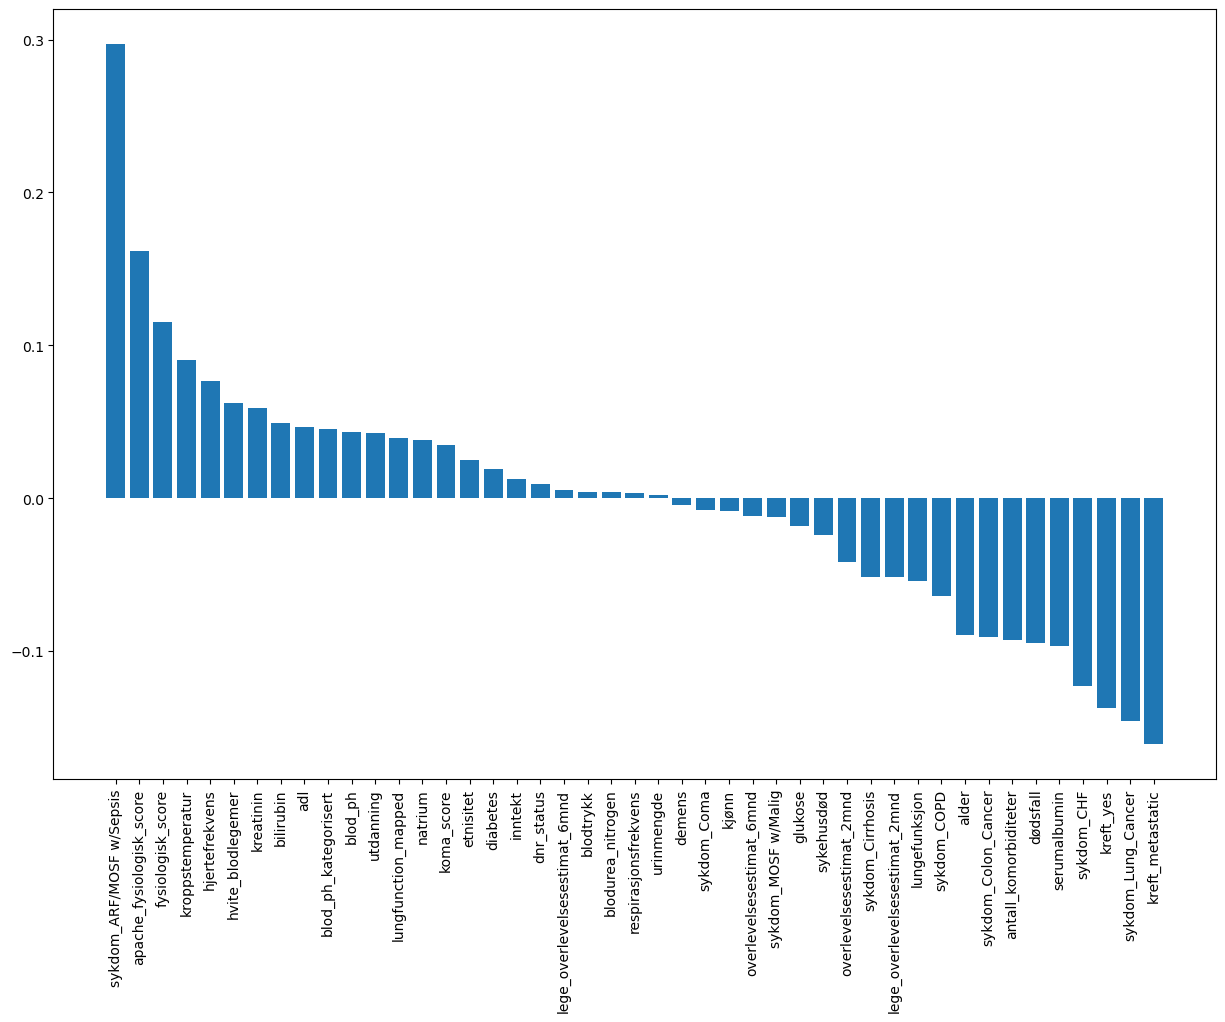

In [1290]:
correlation=train_df.corr()
corr_target=correlation['oppholdslengde'].sort_values(ascending=False)
corr_target.drop('oppholdslengde', inplace=True)

plt.figure(figsize=(15,10))
plt.bar(corr_target.index, corr_target.values)
plt.xticks(rotation=90)


plt.show()


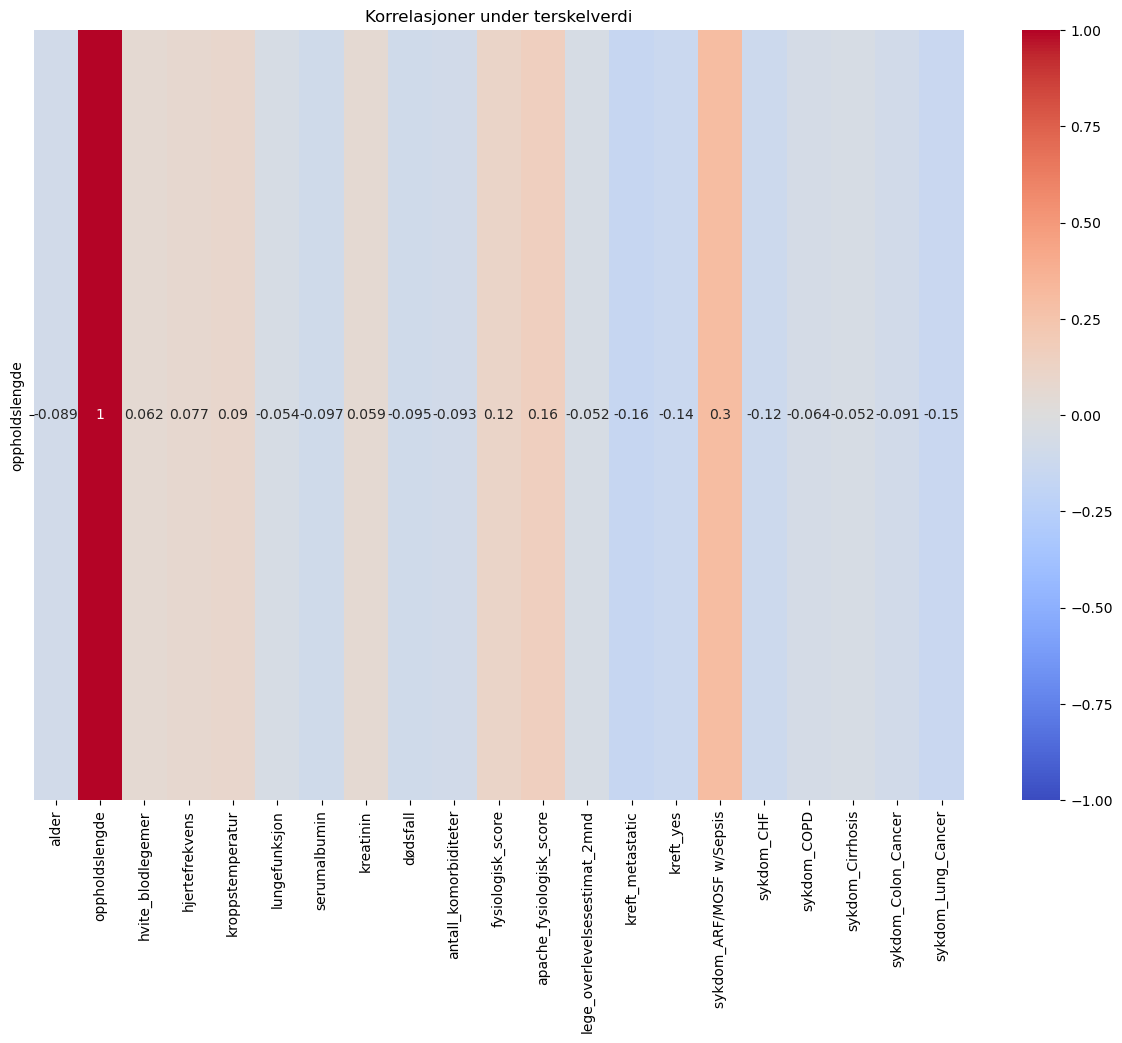

In [1291]:
oppholslengde_corr=correlation['oppholdslengde']
threshold=0.05
high_corr=oppholslengde_corr[np.abs(oppholslengde_corr)>=threshold]
low_corr=oppholslengde_corr[np.abs(oppholslengde_corr)<threshold]

plt.figure(figsize=(15,10))
sns.heatmap(high_corr.to_frame().T, annot=True, cmap='coolwarm',vmin=-1,vmax=1,cbar=True)
plt.title('Korrelasjoner under terskelverdi')
plt.show()

In [1292]:
# Litt dprlig å bruke korrelasjon når vi har binære og kontinuerlige variabler, men lar den stå for nå. 
# Den fanger opp linær antagelse, og sammenheng mellom to variabler. 
# Hvis du prøver å se sammenhengen mellom en sykdom (som er binær: tilstedeværende eller ikke tilstedeværende) 
# og antall dager på sykehuset (kontinuerlig), er ikke forholdet nødvendigvis lineært. 
# For eksempel kan det være en terskel hvor tilstedeværelsen av en sykdom kraftig øker oppholdslengden, men det er ikke en jevn økning.

correlation_matrix=train_df.corr()

fig =px.imshow(correlation_matrix,
               labels=dict(x='Features', y='Features', color='Correlation'),
               x=correlation_matrix.columns,
               y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect='auto')

fig.update_layout(
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    autosize=False,
    height=1000,
    width=1000

)
fig.show()

In [1300]:
#Når vi har fått puttet inn for NaN verider er det lurt å bruke mutual information for å se hvilke features som er viktigst.
# ettersom den korrelasjonen vi har brukt gjerne går glipp av, siden vi har linære og ikke linære sammenhenger.
# måler hvor mye informasjon en variabel gir oss om en annen. Den kan fange opp alle slags forhold, enten lineære eller ikke-lineære. 
from sklearn.feature_selection import mutual_info_classif
import pandas as pd



X = train_df.drop(columns=['oppholdslengde'])  
y = train_df['oppholdslengde']  


mi = mutual_info_classif(X, y)


mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
})


mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)


print(mi_df_sorted)


ValueError: Input contains NaN

## Model

In [1294]:
#Beskriver 
train_df.describe(include='all')

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,lungfunction_mapped,blod_ph_kategorisert
count,5413.000000,4435.000000,3620.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5281.000000,5413.000000,...,5413,5413,5413,5413,5413,5413,5413,5413,4040.0,4059.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,4.0,3.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,2.0,0.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3313,4614,4842,5128,5121,5040,4856,4977,1409.0,2051.0
mean,62.667997,11.802480,0.936188,0.558470,0.313135,0.261777,17.883059,84.210881,12.411832,97.694624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,15.746510,3.421883,1.040524,0.496615,0.749259,0.439643,21.642808,27.700134,8.989788,31.487143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,52.790990,10.000000,0.000000,0.000000,0.000000,0.000000,6.000000,63.000000,7.000000,72.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65.008000,12.000000,1.000000,1.000000,0.000000,0.000000,11.000000,77.000000,10.699219,100.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,74.107970,14.000000,2.000000,1.000000,0.000000,1.000000,20.000000,107.000000,15.398438,120.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1295]:
# Step 1: Prepare the feature matrix (X) and target vector (y)
X = train_df.drop('oppholdslengde', axis=1)
y = train_df['oppholdslengde']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Instantiate and train the RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rfr.fit(X_train, y_train)

# Step 4: Use the score() method to get the R² score on test data
r2_score = rfr.score(X_test, y_test)

# Step 5: Print the R² score
r2_score

#tester på test data, jo høyere jo bedre. 
#r2 score forteller hvor godt modellen forklarer variasjonen i dataene. 16% ganske lavt. 

0.17040671895567083

In [1296]:
kolonne=X.columns
feature_scores = pd.Series(rfr.feature_importances_, index=kolonne).sort_values(ascending=False)
feature_scores

sykdom_ARF/MOSF w/Sepsis         0.086138
alder                            0.056144
apache_fysiologisk_score         0.051110
fysiologisk_score                0.048844
hvite_blodlegemer                0.046067
natrium                          0.041392
lege_overlevelsesestimat_2mnd    0.038567
kreatinin                        0.038283
blodtrykk                        0.036404
overlevelsesestimat_6mnd         0.034888
serumalbumin                     0.033038
lungefunksjon                    0.032740
glukose                          0.032662
utdanning                        0.031683
bilirubin                        0.031673
overlevelsesestimat_2mnd         0.031402
urinmengde                       0.030706
respirasjonsfrekvens             0.029270
kroppstemperatur                 0.029163
lege_overlevelsesestimat_6mnd    0.028782
blod_ph                          0.028390
hjertefrekvens                   0.026057
adl                              0.025615
sykehusdød                       0

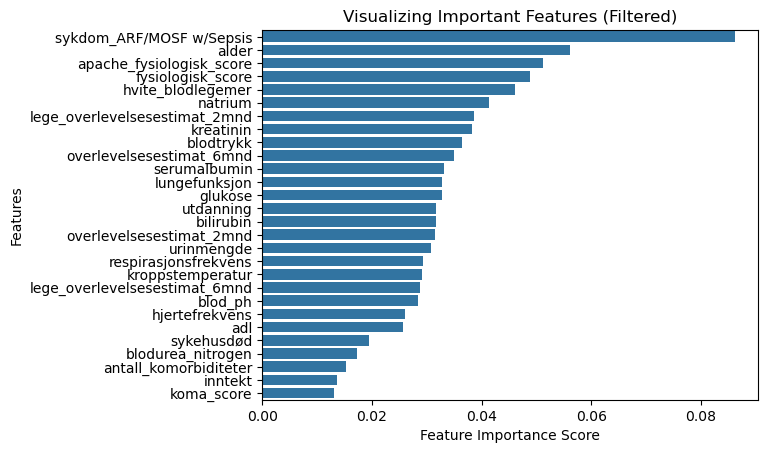

In [1297]:
# Define a threshold for feature importance
threshold = 0.01

# Filter features that have importance scores above the threshold
filtered_feature_scores = feature_scores[feature_scores > threshold]

# Create the seaborn bar plot using the filtered features
sns.barplot(x=filtered_feature_scores, y=filtered_feature_scores.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (Filtered)")

# Display the plot
plt.show()